In [1]:
import numpy as np 
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# load the datasets into dataframe
train = pd.read_csv('data/Multiple Linear Regression.csv')

In [5]:
# show the first few records of train set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.shape

(1460, 81)

In [7]:
# check the missing values
print ('Total missing values in the train dataset', sum(train.isna().sum()))

Total missing values in the train dataset 6965


In [8]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [9]:
#Let's review the relationship between the columns to examine the correlations between the features and the target.
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('Top ten Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('Top ten Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-10:])

Top ten Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

Top ten Uncorrelated Features with SalePrice:
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

Text(0.5, 0, 'GrLivArea (Above grade "ground" living area square feet)')

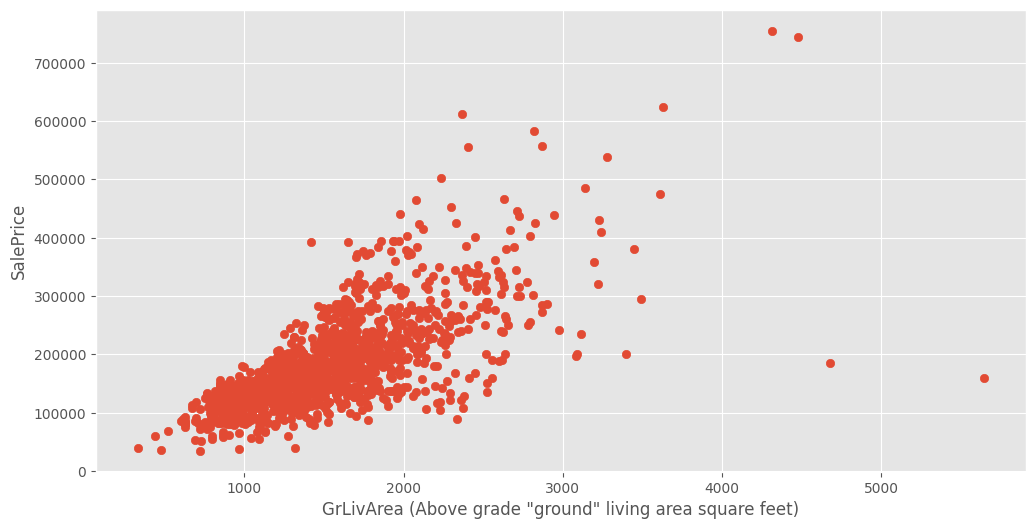

In [10]:
#At first glance, there are increases in living area correspond to increases in price, with few outliers.
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above grade "ground" living area square feet)')

Text(0.5, 0, 'GarageArea')

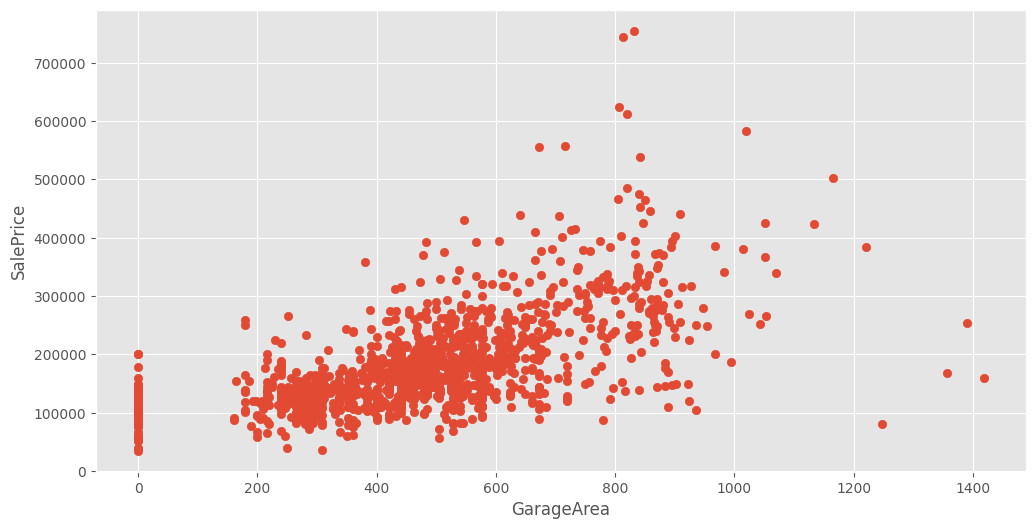

In [11]:
#So there are many homes with 0 for GarageArea and there are a few outliers as well!
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

/var/folders/8_/x1v53ch17ws3blq_fkb02w4h0000gn/T/ipykernel_57046/2054056484.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], hist=True, kde=True,


<Axes: xlabel='SalePrice', ylabel='Density'>

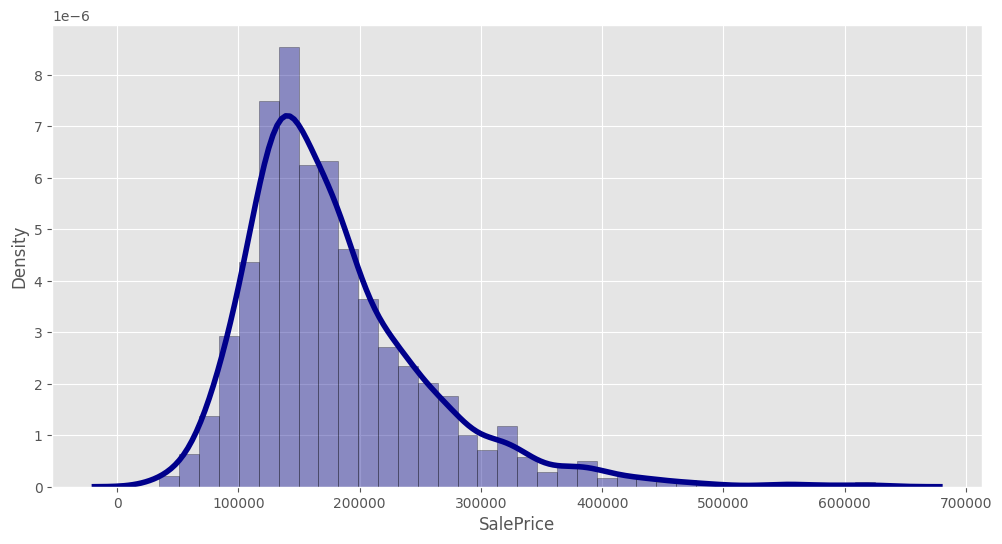

In [15]:
# Density Plot and Histogram of Sales Price..Showcases positive skewness. Tail is to the right of Mean.
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
#
plt.figure(figsize=(12,6))
sns.distplot(train['SalePrice'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [16]:
# remove GrLivArea outliers
train = train[train['GrLivArea'] < 4000]

In [17]:
# remove GarageArea outliers
train = train[train['GarageArea'] < 1200]

In [18]:
# drop columns with percentage of missing values > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.937328
PoolQC         0.996556
Fence          0.807163
MiscFeature    0.963499
dtype: float64


In [19]:
# Encode categorical variables to numeric as model cannot process text values.
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [20]:
# fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [21]:
# It can be easily done via Numpy, just by calling the log() function on the desired column. 
# You can then just as easily check for skew:
# Apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [22]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,4.110874,3,4.189655,9.042040,1,3,3,0.0,4,...,0.000000,0.0,0.0,0.0,0.0,2,2008,8,4,12.247699
1,2,3.044522,3,4.394449,9.169623,1,3,3,0.0,2,...,0.000000,0.0,0.0,0.0,0.0,5,2007,8,4,12.109016
2,3,4.110874,3,4.234107,9.328212,1,0,3,0.0,4,...,0.000000,0.0,0.0,0.0,0.0,9,2008,8,4,12.317171
3,4,4.262680,3,4.110874,9.164401,1,0,3,0.0,0,...,5.609472,0.0,0.0,0.0,0.0,2,2006,8,0,11.849405
4,5,4.110874,3,4.442651,9.565284,1,0,3,0.0,2,...,0.000000,0.0,0.0,0.0,0.0,12,2008,8,4,12.429220


/var/folders/8_/x1v53ch17ws3blq_fkb02w4h0000gn/T/ipykernel_57046/2986893503.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], hist=True, kde=True,


<Axes: xlabel='SalePrice', ylabel='Density'>

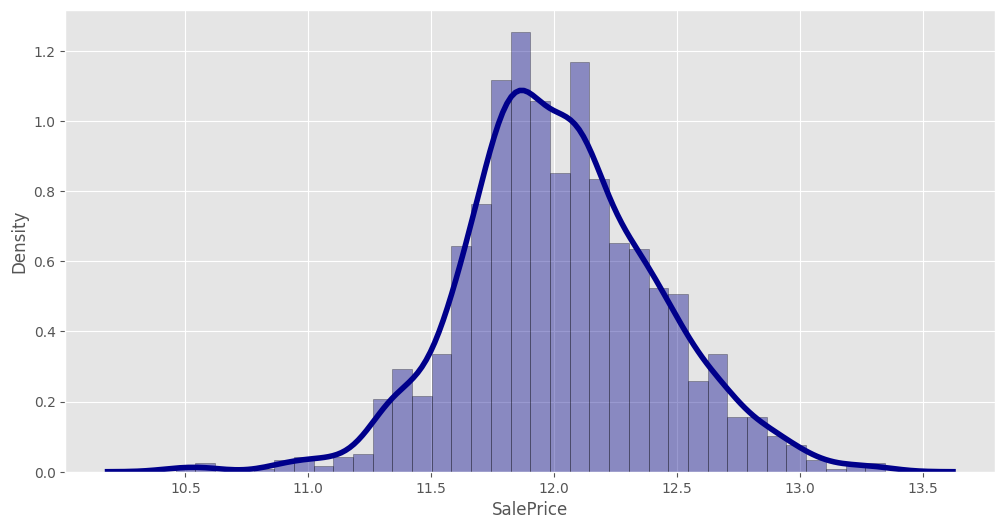

In [23]:
# Density Plot and Histogram of Sales Amount..Showcases close to normal distribution.
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
#
plt.figure(figsize=(12,6))
sns.distplot(train['SalePrice'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [24]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
lr = linear_model.LinearRegression()

#### Let's use the fit method to "fit" the model to the dataset. This will ingest the data and "learn" from it.

In [26]:
model = lr.fit(X_train, y_train)

In [27]:
# make predictions based on model
predictions = model.predict(X_test)

In [28]:
model.score(X_test, y_test)

0.907577075828029

In [29]:
#pick a sampel to manually test it
X_test[:1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1040,3.044522,3,4.488636,9.48235,1,3,3,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2006,8,4


In [30]:
model.predict(X_test[:1])

array([11.85797574])

In [31]:
# To get the actual sale price we use the inverse of numpy.log1p()
back = np.expm1(11.8587895)
back

141320.04556369197

In [34]:
# Get the data to check the index and price
df = pd.read_csv('data/train.csv')
df.iloc[1040]

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

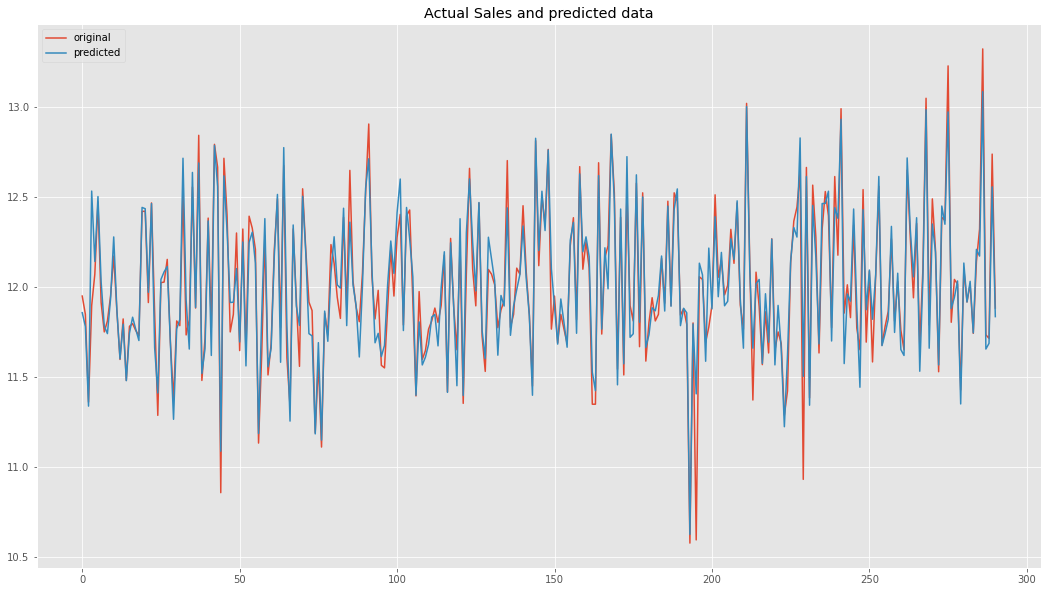

In [30]:
plt.figure(figsize=(18,10))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax,predictions, label="predicted")
plt.title("Actual Sales and predicted data")
plt.legend()
plt.show()